In [ ]:
import pathlib
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Drive**

In [ ]:
data_dir ='/content/drive/MyDrive/Coba/Kain'
pthlib = pathlib.Path(data_dir)
image_count = len(list(pthlib.glob('*/*.jpg')))
print(image_count)

448


#**Prepros**

In [ ]:
panjang=224
lebar=224
batch=30

In [ ]:
#def to_grayscale_then_rgb(image):
  #  image = tf.image.rgb_to_grayscale(image)
   # return image

datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=30,
    brightness_range=[0.5,1.5],
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2
)



In [ ]:
train_generator = datagen.flow_from_directory(data_dir,
                                              target_size = (panjang, lebar),
                                              batch_size = batch,
                                              class_mode = 'categorical',
                                              subset = 'training',
                                              shuffle = False)

Found 359 images belonging to 2 classes.


In [ ]:
val_generator=datagen.flow_from_directory(
    data_dir,
    target_size=(panjang,lebar),
    batch_size= batch,
    class_mode='categorical',
    subset= 'validation',
    shuffle=False
)

Found 89 images belonging to 2 classes.


#Inception

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (224,224,3),
                                include_top = False,
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False


--2023-06-03 14:21:59--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.196.128, 173.194.197.128, 64.233.191.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.196.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   177MB/s    in 0.5s    

2023-06-03 14:21:59 (177 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
pre_trained_model.summary()

# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed6')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
x= layers.Dropout(0.5)(x)
x = layers.Dense  (2, activation='softmax')(x)

# Append the dense network to the base model
model = Model(pre_trained_model.input, x)

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

#compile and epoch

In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer = Adam(learning_rate=0.001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
result = model.fit(
            train_generator,
            validation_data = val_generator,
            steps_per_epoch = train_generator.samples//batch,
            epochs = 20,
            validation_steps = val_generator.samples//batch,
            verbose = 1)

Epoch 1/20
11/11 [==============================] - 110s 9s/step - loss: 24.9883 - accuracy: 0.6413 - val_loss: 2.4815 - val_accuracy: 0.7167
Epoch 2/20
11/11 [==============================] - 69s 6s/step - loss: 2.3300 - accuracy: 0.6292 - val_loss: 1.5314 - val_accuracy: 0.7000
Epoch 3/20
11/11 [==============================] - 69s 6s/step - loss: 0.7386 - accuracy: 0.8359 - val_loss: 0.3268 - val_accuracy: 0.8667
Epoch 4/20
11/11 [==============================] - 69s 6s/step - loss: 0.3280 - accuracy: 0.8909 - val_loss: 0.5002 - val_accuracy: 0.8333
Epoch 5/20
11/11 [==============================] - 64s 6s/step - loss: 0.2469 - accuracy: 0.9210 - val_loss: 0.2237 - val_accuracy: 0.9167
Epoch 6/20
11/11 [==============================] - 68s 6s/step - loss: 0.2364 - accuracy: 0.9152 - val_loss: 0.1206 - val_accuracy: 0.9667
Epoch 7/20
11/11 [==============================] - 67s 6s/step - loss: 0.2329 - accuracy: 0.9240 - val_loss: 0.1373 - val_accuracy: 0.9667
Epoch 8/20
11/11 [

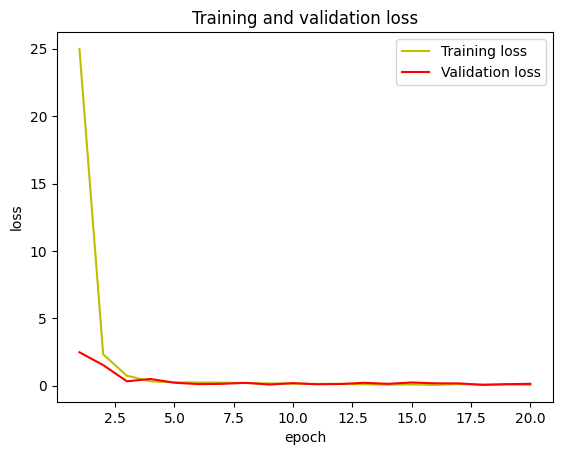

In [ ]:
loss = result.history['loss']
val_loss = result.history['val_loss']
epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'y',label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

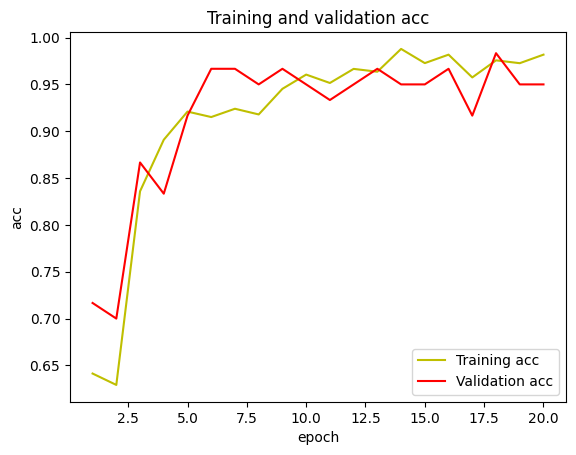

In [ ]:
acc = result.history['accuracy']
val_acc = result.history['val_accuracy']
epochs = range(1,len(loss)+1)

plt.plot(epochs,acc,'y',label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model
model.save('/content/drive/MyDrive/model_kain.h5')
model=load_model('/content/drive/MyDrive/model_kain.h5')

In [ ]:
from keras.models import load_model
model=load_model('/content/mdlh5.h5')

In [ ]:
#prep nyamain format
img = cv2.imread('/content/bopal1.jpg')
img = cv2.resize(img, (150,150))

img = np.expand_dims(img, axis=0)

In [ ]:
prediksi = model.predict(img)

1/1 [==============================] - 1s 1s/step


In [ ]:
baca = tf.nn.softmax(prediksi[0])
baca

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.5761169 , 0.21194157, 0.21194157], dtype=float32)>

In [ ]:
class_name = train_generator.class_indices
class_name = list(dict.keys(class_name))
print(class_name)

['Kain', 'Organik']


In [ ]:
kelas_prediksi = class_name[np.argmax(baca)]
conf = 100*max(baca)
#conf = round(100*max(baca),2)

In [ ]:
#print('Gambar diprediksi sebagai {}'.format(kelas_prediksi))
print('Gambar diprediksi sebagai {},dengan konfiden {}%'.format(kelas_prediksi,conf))

Gambar diprediksi sebagai kaca 2,dengan konfiden 57.611690521240234%


In [ ]:
image_path = '/content/kain6.jpg'
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
image_array = tf.keras.preprocessing.image.img_to_array(image)
image_array = tf.expand_dims(image_array, 0)
image_array = image_array / 255.0  # Normalisasi

In [ ]:
predictions = model.predict(image_array)
predicted_class = tf.argmax(predictions[0])

1/1 [==============================] - 0s 182ms/step


In [ ]:
description = ""
if predicted_class == 0:
    description = "Ini adalah kain."
elif predicted_class == 1:
    description = "Ini adalah barang organik."


print(description)

Ini adalah barang organik.
